<a href="https://colab.research.google.com/github/EdwSanA/DPro_Tareas/blob/main/Previsiones_de_precios_vivienda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape del dataset: (1460, 81)
Shape tras quitar faltantes en las columnas usadas: (1460, 3)

INFO: LinearRegression / Árbol / RandomForest no requieren escalado; SVR sí se entrena con features escaladas.

  Regresión Lineal | MSE: 2314465093 | RMSE: 48109 | R²: 0.670
         SVM (RBF) | MSE: 6028358471 | RMSE: 77643 | R²: 0.139
 Árbol de Decisión | MSE: 2367486599 | RMSE: 48657 | R²: 0.662
  Bosque Aleatorio | MSE: 1642783518 | RMSE: 40531 | R²: 0.765

=== Comparación de modelos (ordenado por RMSE) ===
              Modelo           MSE          RMSE        R2
0   Bosque Aleatorio  1.642784e+09  40531.265934  0.765494
1   Regresión Lineal  2.314465e+09  48108.887877  0.669613
2  Árbol de Decisión  2.367487e+09  48656.824796  0.662044
3          SVM (RBF)  6.028358e+09  77642.504279  0.139459


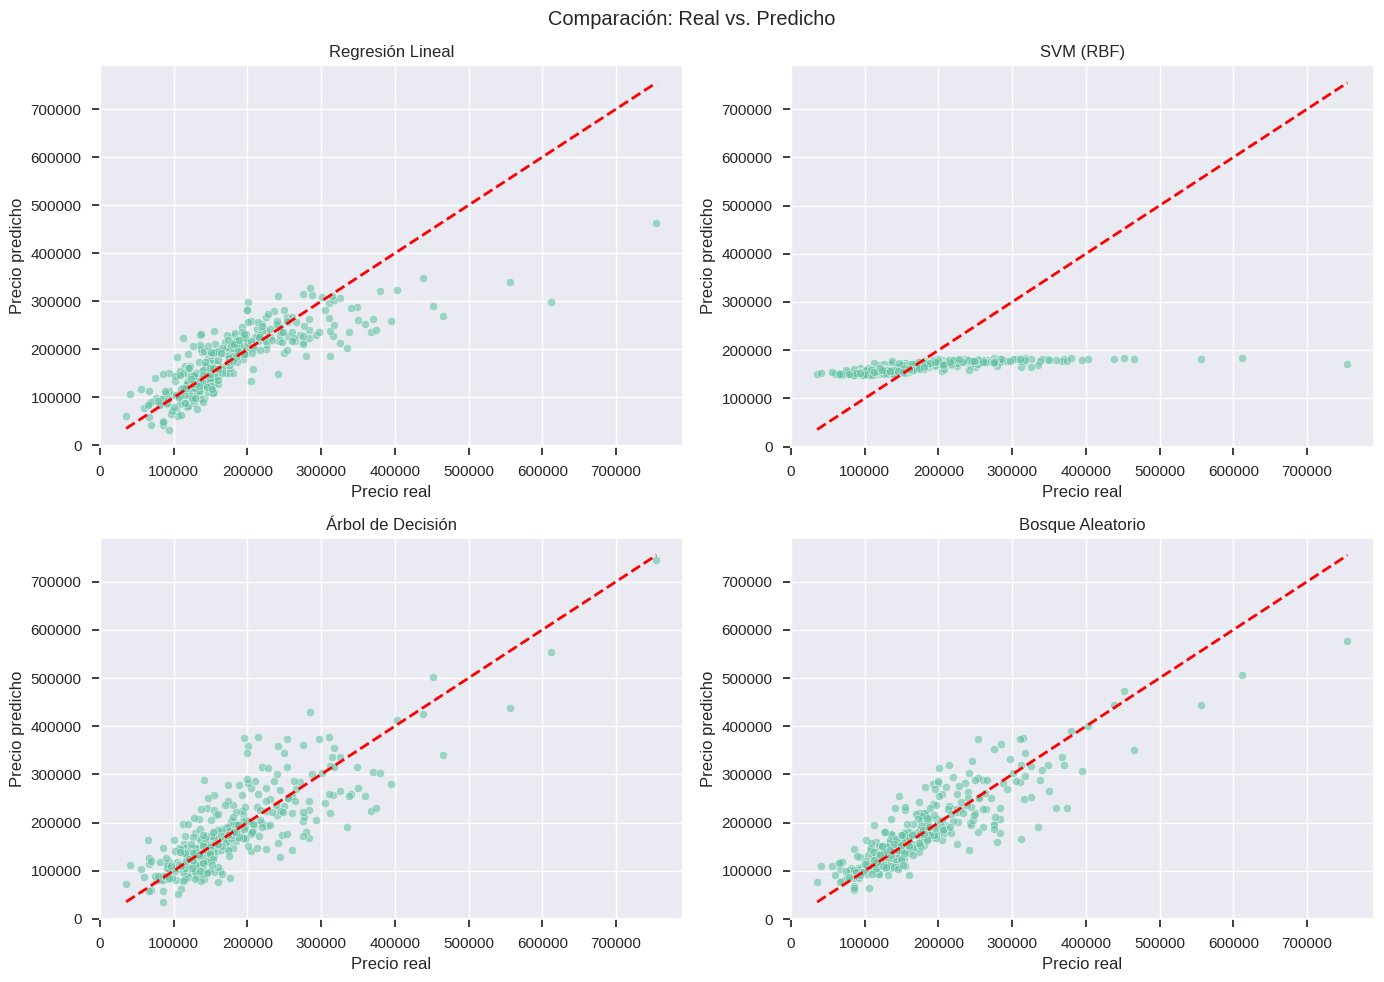

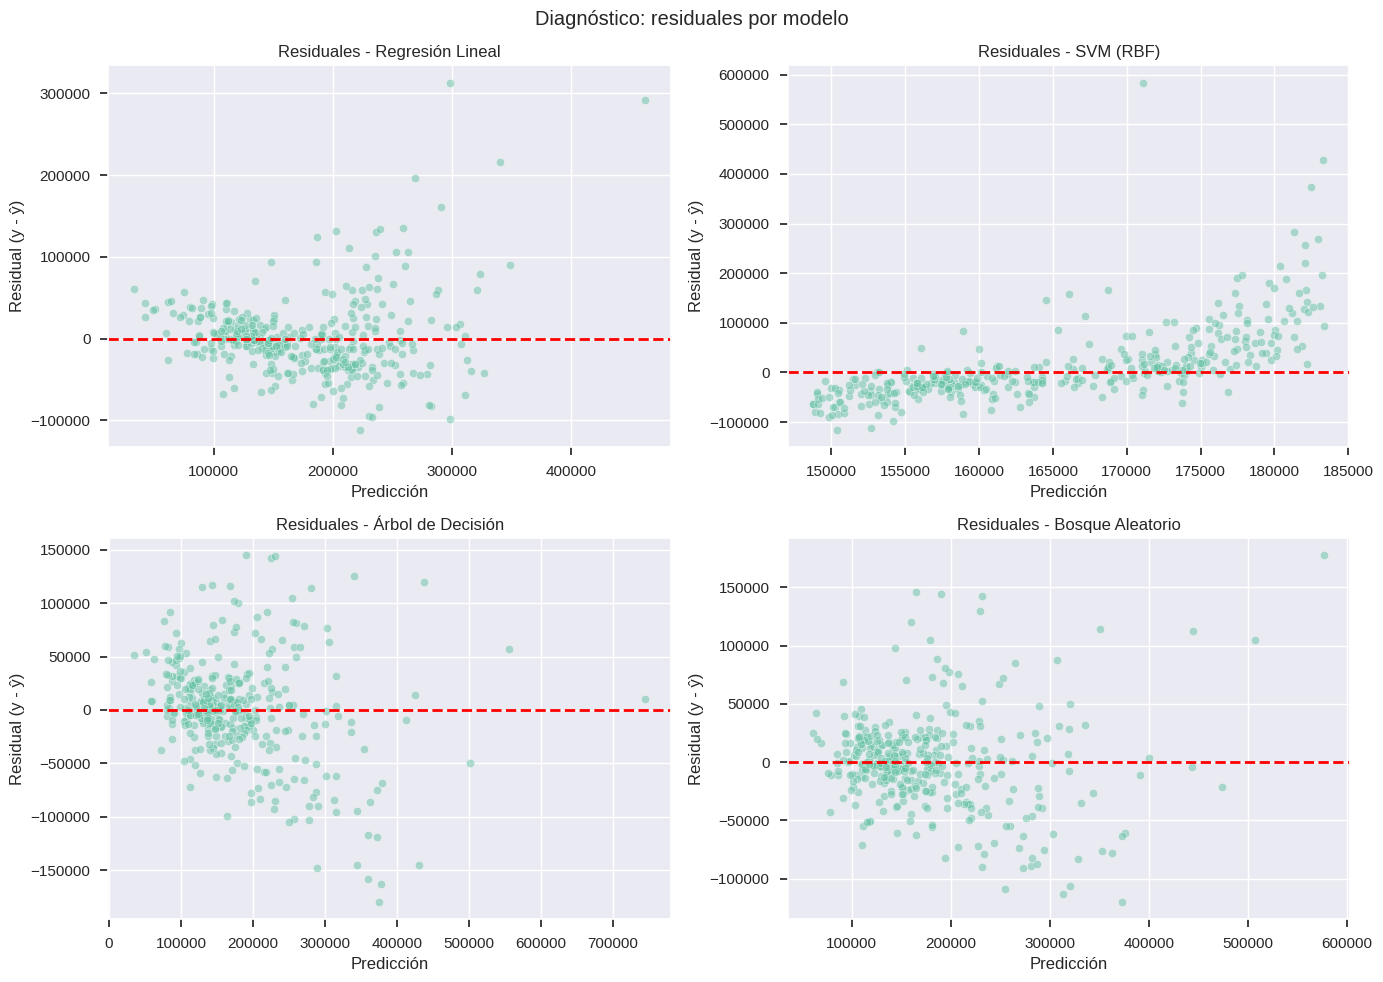

In [4]:
# ===============================
# REGRESIÓN DE PRECIOS (Ames)
# ===============================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# --- estilo
plt.style.use("seaborn-v0_8")
sns.set_context("notebook")
sns.set_palette("Set2")

# ========== 1) Cargar train.csv ==========
csv_name = "train.csv"
if not os.path.exists(csv_name):
    try:
        # Colab: habilita subida manual si no está el archivo
        from google.colab import files
        print("No se encontró 'train.csv'. Sube el archivo desde tu PC…")
        uploaded = files.upload()
        csv_name = list(uploaded.keys())[0]
    except Exception:
        raise FileNotFoundError("Sube 'train.csv' al entorno de ejecución.")

df = pd.read_csv(csv_name)
print("Shape del dataset:", df.shape)

# ========== 2) Selección de variables ==========
# Variables simples para comenzar (como pide la consigna)
FEATURES = ["GrLivArea", "YearBuilt"]
TARGET = "SalePrice"

# Mantener solo columnas necesarias y quitar faltantes en estas
df_subset = df[FEATURES + [TARGET]].dropna()
print("Shape tras quitar faltantes en las columnas usadas:", df_subset.shape)

X = df_subset[FEATURES]
y = df_subset[TARGET]

# Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Escalado SOLO para modelos sensibles (SVR)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print("\nINFO: LinearRegression / Árbol / RandomForest no requieren escalado; SVR sí se entrena con features escaladas.\n")

# ========== 3) Modelos ==========
models = {
    "Regresión Lineal": LinearRegression(),
    "SVM (RBF)": SVR(kernel="rbf", C=100, gamma=0.1),
    "Árbol de Decisión": DecisionTreeRegressor(random_state=42),
    "Bosque Aleatorio": RandomForestRegressor(n_estimators=200, random_state=42)
}

def evaluar_modelo(nombre, modelo, Xtr, Xte, usar_scaler=False):
    """Entrena y evalúa un modelo, devolviendo dict con métricas y y_pred."""
    if usar_scaler:
        modelo.fit(X_train_scaled, y_train)
        y_pred = modelo.predict(X_test_scaled)
    else:
        modelo.fit(X_train, y_train)
        y_pred = modelo.predict(X_test)

    mse  = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_test, y_pred)
    return {
        "Modelo": nombre,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "y_pred": y_pred
    }

resultados = []
for nombre, modelo in models.items():
    usar_scaler = nombre.startswith("SVM")
    res = evaluar_modelo(nombre, modelo, X_train, X_test, usar_scaler=usar_scaler)
    resultados.append(res)
    print(f"{nombre:>18} | MSE: {res['MSE']:.0f} | RMSE: {res['RMSE']:.0f} | R²: {res['R2']:.3f}")

# Tabla ordenada por RMSE (menor = mejor)
tabla = pd.DataFrame([{k: v for k, v in r.items() if k in ["Modelo","MSE","RMSE","R2"]} for r in resultados])
tabla = tabla.sort_values(by="RMSE", ascending=True).reset_index(drop=True)

print("\n=== Comparación de modelos (ordenado por RMSE) ===")
print(tabla)

# ========== 4) Visualizaciones ==========
# 4.1 Predicho vs Real para cada modelo
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, res in zip(axes, resultados):
    y_pred = res["y_pred"]
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, ax=ax)
    # diagonal
    minv, maxv = y_test.min(), y_test.max()
    ax.plot([minv, maxv], [minv, maxv], "r--", lw=2)
    ax.set_title(res["Modelo"])
    ax.set_xlabel("Precio real")
    ax.set_ylabel("Precio predicho")

plt.suptitle("Comparación: Real vs. Predicho")
plt.tight_layout()
plt.show()

# 4.2 Residuales (y_true - y_pred) para diagnóstico rápido
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, res in zip(axes, resultados):
    y_pred = res["y_pred"]
    residuales = y_test - y_pred
    sns.scatterplot(x=y_pred, y=residuales, alpha=0.5, ax=ax)
    ax.axhline(0, color="r", linestyle="--", lw=2)
    ax.set_title(f"Residuales - {res['Modelo']}")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Residual (y - ŷ)")

plt.suptitle("Diagnóstico: residuales por modelo")
plt.tight_layout()
plt.show()
